<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/T2_Relaxation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2018.1.0


#Load pre-defined functions

In [3]:
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py

from DmriFemBuitInFunc import *

class MRI_parameters():
    def __init__(self):
        # Initialize default parameters
        self.bvalue = None
        self.qvalue = None        
        self.gdir = [1, 0, 0];
        self.stype='PGSE'
        self.nperiod = 0; # number of period for OGSE sequences
        self.T2 = 1e16
    def set_gradient_dir(self, mymesh, g0, g1, g2):
        gdim = mymesh.geometry().dim()
        if gdim==2:
            self.gdir = Point(g0, g1)
            self.gdir /= self.gdir.norm()
            self.g = Expression(("g0","g1"), g0=self.gdir.x(), g1=self.gdir.y(),domain=mymesh, degree=1);
        if gdim==3:
            self.gdir = Point(g0, g1, g2)
            self.gdir /= self.gdir.norm()        
            self.g = Expression(("g0","g1","g2"), g0=self.gdir.x(), g1=self.gdir.y(), g2=self.gdir.z(),domain=mymesh, degree=1);
    def time_profile(self, t):
        ft1, ft2 = 0, 0;
        if self.stype=='PGSE':
            ft1 = 1.0*(t>=0 and t<self.delta) 
            ft2 = -1.0*(t>=self.Delta and t<=self.Delta+self.delta);
        if self.stype=='cos_OGSE':
            ft1 =  cos(2.0*self.nperiod*pi*t/self.delta)*(t>=0 and t<self.delta);
            ft2 = -cos(2.0*self.nperiod*pi*(t-2.*self.delta)/self.delta)*(t>=Delta and t<=self.Delta+self.delta);
        return ft1 + ft2; 
    def itime_profile(self, t): 
        # integrate ft
        ft1, ft2, ft3 = 0, 0, 0;
        if self.stype=='PGSE':
            ft1 = t*(t>=0 and t<self.delta) 
            ft2 = self.delta*(t>=self.delta and t<self.Delta) 
            ft3 = (self.delta - t + self.Delta)*(t>=self.Delta and t<=self.Delta+self.delta) 
        if self.stype=='cos_OGSE':
 	          ft1 = 1.0/2.0*self.delta*sin(2.0*t*self.nperiod*pi/self.delta)/self.nperiod/pi * (t >= 0 and  t <= self.delta)
 	          ft2 = 1.0/2.0*self.delta*(sin(2.0*self.Delta*self.nperiod*pi/self.delta)-sin(2.0*t*self.nperiod*pi/self.delta))/nperiod/pi *(t>=self.Delta and t<=self.Delta+self.delta)
        return ft1 + ft2 + ft3;  
    def convert_b2g(self):
        self.gnorm = 0;
        if (self.stype == 'PGSE'):
            self.gnorm = sqrt(self.bvalue)/sqrt(self.delta*self.delta*(self.Delta-self.delta/3.0));
        if (self.stype == 'cos_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        if (self.stype == 'sin_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        return self.gnorm
    def convert_g2b(self):
        self.bvalue = 0;
        if (self.stype == 'PGSE'):
            self.bvalue = self.gnorm*self.gnorm*self.delta*self.delta*(self.Delta-self.delta/3.0);
        if (self.stype == 'cos_OGSE'):
            self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        if (self.stype == 'sin_OGSE'):
	          self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        return self.bvalue
      
    def Apply(self):
        self.T = self.Delta+self.delta;
        if not(self.bvalue==None):
            self.gnorm = self.convert_b2g();
            self.qvalue = convert_g2q(self.gnorm);
        elif not(self.qvalue==None):
            self.gnorm = convert_q2g(self.qvalue);
            self.bvalue = self.convert_g2b();
        elif (self.bvalue==None and self.bvalue==None):
            print("bvalue or qvalue need to be specified.")
            sys.exit()      
          
class MRI_simulation():
    def __init__(self):
          self.nskip = 5;    # Output frequency (for visualization only)
          self.theta = 0.5;  # theta=0.5: midpoint method

    def InitialCondition(self, mydomain):
          if mydomain.gdim==2:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          if mydomain.gdim==3:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          Dirac_Delta = interpolate(Dirac_Delta, mydomain.V);
          u_0 = Function(mydomain.W);
          assign(u_0.sub(0), Dirac_Delta)
          if (mydomain.IsDomainMultiple==True):
              assign(u_0.sub(2), Dirac_Delta)  
          return Dirac_Delta, u_0
        
    def solve(self, mydomain, mri_para, linsolver): 
      
          self.Dirac_Delta, self.u_0 = self.InitialCondition(mydomain)
          
          stepcounter = 0;

          M = MassMatrix(mydomain);

          self.t = 0;
          ft_prev  =  mri_para.time_profile(self.t);
          ift_prev = mri_para.itime_profile(self.t);

          start_time = time.time()
          
          while self.t < mri_para.T + self.k: # Time-stepping loop
              if stepcounter % self.nskip == 0:
                  print('t: %f '%self.t, 'T: %.1f'%mri_para.T, 'dt: %.1f'%self.k,'gnorm: %e'%mri_para.gnorm,'Completed %.2f%%'%(float(self.t)/float(mri_para.T+mri_simu.k)*100.0));

              ft = mri_para.time_profile(self.t);
              ift = mri_para.itime_profile(self.t);
              L = ThetaMethodL(ft_prev, ift_prev, mri_para, self, mydomain);
              A = 1/self.k*M + assemble(ThetaMethodF(ft, ift, mri_para, self, mydomain))

              b = assemble(L);
              
              linsolver.solve(A, self.u_0.vector(),b);

              ft_prev  = ft;
              ift_prev = ift;

              self.t += self.k;
              stepcounter += 1;

          self.elapsed_time = time.time() - start_time
          print("Successfully Completed! Elapsed time: %f seconds"%self.elapsed_time)
def Post_processing(mydomain, mri_sim):
    one = Function(mydomain.V)
    one.vector()[:] = 1
    whole_vol = assemble(one*dx)
    voi = assemble(mri_simu.Dirac_Delta*dx)
    if mydomain.IsDomainMultiple == True:
        u0r_0, u0i_0, u1r_0, u1i_0 = split(mri_simu.u_0)
        signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx)/assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
        signal1 = assemble((mydomain.phase*u1r_0)*dx)/assemble(mydomain.phase*mri_simu.Dirac_Delta*dx);
        signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx);
        print('Signal on each compartment')
        print('Signal0: %.3e'%signal0)
        print('Signal1: %.3e'%signal1)
        out_text = 'b: %.3f , Signal: %.3e, Normalized signal: %.3e, kappa: %.3e, dt: %.3f, hmin: %.3f, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, signal, signal/voi, mydomain.kappa, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*D0), mri_sim.elapsed_time)
        V0 = FunctionSpace(mesh0, mydomain.Ve);
        V1 = FunctionSpace(mesh1, mydomain.Ve);
        u0r_0p = project(u0r_0,V0)
        u1r_0p = project(u1r_0,V1)
        plot(u0r_0p, cmap="coolwarm")
        plot(u1r_0p, cmap="coolwarm")  
    else:
        ur, ui = split(mri_simu.u_0)
        signal = assemble(ur*dx);
        out_text = 'b: %.3f, Signal: %.3e, Normalized signal: %.3e, dt: %.3f, hmin: %.3f, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, signal, signal/voi, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*D0), mri_sim.elapsed_time)
        V = FunctionSpace(mymesh,mydomain.Ve);
        ur_p = project(ur,V)
        plot(ur_p, cmap="coolwarm")

    print(out_text)
    print("save to log.txt")
    outfile = open('log.txt', 'a')
    outfile.write(out_text)
    outfile.close()  

Load pre-defined functions from GitHub


# Working on the mesh and submesh

Extracting cell markers from: multi_layered_cylinder.msh ...
Extracted successfully on: 7200 elements
Partition marker list: ['0', '1', '2']
Wrote to: pmk_multi_layered_cylinder.xml
Partition markers: [0, 1, 2]


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:not adjusting title pos because title was already placed manually: 0.920000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title 

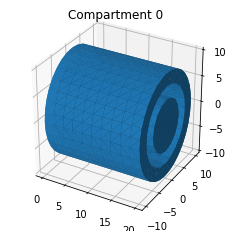

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:not adjusting title pos because title was already placed manually: 0.920000
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


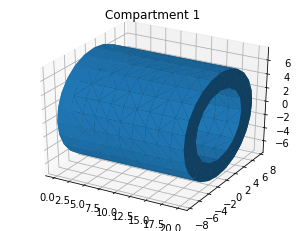

In [4]:
geo_choice = 2
################################################################################
############## Create two-layered disk using mshr in FEniCS ####################
if geo_choice == 1:
    R1, R2 = 5, 10;
    origin = Point(0.,0.)
    circle = Circle(origin, R1, segments=32)
    domain = Circle(origin, R2, segments=32)
    domain.set_subdomain(1, circle)
    mymesh = generate_mesh(domain, 15) # 15 is the resolution
    cmpt_mesh = generate_mesh(circle, 15)
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)    

################################################################################
############## Create multilayered domains using gmsh ##########################
if geo_choice == 2:
    # mesh_name = "multi_layered_disk"
    mesh_name = "multi_layered_cylinder"
    # mesh_name = "multi_layered_sphere"
    is_partition_function_exist = os.path.isfile('GetPartitionMarkers.py')
    if is_partition_function_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py

    is_geo_file_exist = os.path.isfile(mesh_name+'.geo')  
    if is_geo_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

    # Modify .geo file from 4 layers to 3 layers      
    !sed -i 's/5, 7.5, 10, 13/5, 7.5, 10/g' $mesh_name''.geo
      
    # Create mesh from geo file by gmsh
    !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh
    
    # Convert .msh to .xml using dolfin-convert
    !dolfin-convert $mesh_name''.msh $mesh_name''.xml
    clear_output()

    mymesh = Mesh(mesh_name+".xml");  

    from GetPartitionMarkers import *

    GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

    partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

    File("pmk_"+mesh_name+".xml")>>partition_marker

    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, None, partition_marker)    

################################################################################
############## Download the existing mesh and submesh ##########################
if geo_choice == 3:
    is_file_exist = os.path.isfile("multi_layer_torus.xml")  
    if is_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip
        !unzip -q multi_layer_torus.xml.zip
        !unzip -q multi_layer_torus_compt1.xml.zip
        !rm -rf *.zip *MACOSX

    mymesh = Mesh("multi_layer_torus.xml");  
    cmpt_mesh = Mesh('multi_layer_torus_compt1.xml')
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)    
    
################################################################################
############## Save, Plot phase functions and submeshes to verify ##############
print("Partition markers:", partion_list)
if mymesh.topology().dim()==2:
    print(cellmarker, partition_marker)
    plt.subplot(1, 2, 1); plot(cellmarker, cmap="coolwarm", title="Cell marker");
    plt.subplot(1, 2, 2); plot(partition_marker, cmap="coolwarm",  title="Partition marker");
mesh0 = SubMesh(mymesh, cellmarker, 0)
mesh1 = SubMesh(mymesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1
plt.figure(2); plot(mesh0, title="Compartment 0") 
plt.figure(3); plot(mesh1, title="Compartment 1")

# Solve the Bloch-Torrey equation

Function Space for Two-compartment Domains has 4 components
(ur0, ui0, ur1, ur1): r-real, i-imaginary
Initialize a standard function space.
t: 0.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 0.00%
t: 1000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 4.95%
t: 2000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 9.90%
t: 3000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 14.85%
t: 4000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 19.80%
t: 5000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 24.75%
t: 6000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 29.70%
t: 7000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 34.65%
t: 8000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 39.60%
t: 9000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 44.55%
t: 10000.000000  T: 20000.0 dt: 200.0 gnorm: 0.000000e+00 Completed 49.50%
t: 11000.000000  T: 20000.0 dt: 200.0 gnorm: 0.0000

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


b: 0.000 , Signal: 6.243e+03, Normalized signal: 1.000e+00, kappa: 1.000e-05, dt: 200.000, hmin: 2.399, whole_vol: 6242.890, vol_of_interest: 6242.890, Free signal: 1.000e+00, elasped time 77.205 (s)

save to log.txt


DEBUG:matplotlib.axes._base:update_title_pos


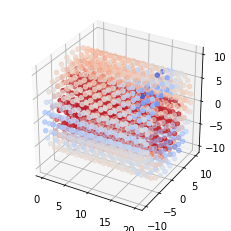

In [5]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.stype='PGSE'                                # sequence type
mri_para.bvalue = 0;                                 # bvalue
mri_para.delta, mri_para.Delta = 10000, 10000        # time sequence
mri_para.set_gradient_dir(mymesh, 0, 1, 0)           # gradient direction
mri_para.Apply()
mri_simu.k = 200;                                    # time-step size
mri_simu.nskip = 5;                                  # frequency to print ouputs

mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = phase
mydomain.PeriodicDir = [0, 0, 0];            # Direction of the periodicity
mydomain.IsDomainPeriodic = True             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = True             # Confirm if the mesh is multiple
mydomain.kappa = 1e-5                        # Permeability
################################################################################

mydomain.Apply()   # Call Apply before setting the diffusion tensor

################################################################################
D0 = 3e-3          # Setting the diffusion coefficient
mydomain.D = D0
############################# Setting T2-relaxation #############################
add_T2 = False
if add_T2 == True:
    T2_array=[8e4, 4e4, 8e4]
    dofmap_DG = mydomain.V_DG.dofmap()
    T2 = Function(mydomain.V_DG); 

    for cell in cells(mymesh):
        p = cell.midpoint() # the coordinate of the cell center.
        cmk = partition_marker[cell.index()]
        cell_dof = dofmap_DG.cell_dofs(cell.index())
        T2.vector()[cell_dof] = T2_array[cmk]; 
    mri_para.T2 = T2
else:
    mri_para.T2 = 1e20
#################################################################################
#################################################################################

#linsolver = PETScLUSolver("mumps")
linsolver = KrylovSolver("bicgstab")
#linsolver.parameters["absolute_tolerance"] = 1e-4
#linsolver.parameters["relative_tolerance"] = 1e-3
#linsolver.parameters["maximum_iterations"] = 1000

mri_simu.solve(mydomain, mri_para, linsolver)

Post_processing(mydomain, mri_simu)

# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)


# # # # # # # # # # # # # # # # D.I.S.K # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=40000 # # # ## # # # # # # # # #
# # # # # # # # # # mydomain.PeriodicDir = [0, 0, 0];
# D=3e-3 mm^2/s, kappa=5e-5m/s
#  bvalue    # signal attenuation
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  7.181e-01
#  2.000e+03 #  5.234e-01
#  3.000e+03 #  3.899e-01
#  4.000e+03 #  2.990e-01
#  5.000e+03 #  2.373e-01
#  6.000e+03 #  1.952e-01
#  7.000e+03 #  1.661e-01
#  8.000e+03 #  1.454e-01
#  9.000e+03 #  1.302e-01
#  1.000e+04 #  1.184e-01
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# D=[3 1 3]*1e-3 mm^2/s, kappa=1e-5m/s
#  0.000e+00 # 1.000e+00
#  1.000e+03 # 7.297e-01
#  2.000e+03 # 5.525e-01
#  3.000e+03 # 4.381e-01
#  4.000e+03 # 3.649e-01
#  5.000e+03 # 3.181e-01
#  6.000e+03 # 2.877e-01
#  7.000e+03 # 2.672e-01
#  8.000e+03 # 2.522e-01
#  9.000e+03 # 2.402e-01
#  1.000e+04 # 2.297e-01
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #



# # # # # # # # # # # # # # # S.P.H.E.R.E # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=40000 # # # # # # # #  # # # #
# # # # # # # # # # mydomain.PeriodicDir = [0, 0, 0];
# D=3e-3 mm^2/s, kappa=5e-5m/s
#  bvalue    # signal attenuation
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  7.886e-01
#  2.000e+03 #  6.228e-01
#  3.000e+03 #  4.932e-01
#  4.000e+03 #  3.921e-01
#  5.000e+03 #  3.135e-01
#  6.000e+03 #  2.526e-01
#  7.000e+03 #  2.054e-01
#  8.000e+03 #  1.688e-01
#  9.000e+03 #  1.406e-01
#  1.000e+04 #  1.186e-01
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# D=[3 1 3]*1e-3 mm^2/s
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  7.707e-01
#  2.000e+03 #  5.932e-01
#  3.000e+03 #  4.565e-01
#  4.000e+03 #  3.518e-01
#  5.000e+03 #  2.721e-01
#  6.000e+03 #  2.117e-01
#  7.000e+03 #  1.662e-01
#  8.000e+03 #  1.321e-01
#  9.000e+03 #  1.065e-01
#  1.000e+04 #  8.749e-02
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


# # # # # # # # # # # # # # # C.Y.L.I.N.D.E.R # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=10000 # # # # # # # #  # # # #
# D=3e-3 mm^2/s, kappa=5e-5m/s
# gdir=[0, 1, 0]:
# 0.000e+00 #  1.000e+00
# 1.000e+03 #  4.777e-01
# 2.000e+03 #  2.996e-01
# 3.000e+03 #  2.235e-01
# 4.000e+03 #  1.784e-01
# 5.000e+03 #  1.455e-01
# 6.000e+03 #  1.200e-01
# 7.000e+03 #  1.003e-01
# 8.000e+03 #  8.513e-02
# 9.000e+03 #  7.374e-02
# 1.000e+04 #  6.531e-02
# gdir=[1, 0, 0]:
# mydomain.PeriodicDir = [1, 0, 0]: s=exp(-bvalue*D0)
# mydomain.PeriodicDir = [0, 0, 0]:
#  bvalue    # signal attenuation
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  2.588e-01
#  2.000e+03 #  1.191e-01
#  3.000e+03 #  8.646e-02
#  4.000e+03 #  6.591e-02
#  5.000e+03 #  5.008e-02
#  6.000e+03 #  4.019e-02
#  7.000e+03 #  3.460e-02
#  8.000e+03 #  3.083e-02
#  9.000e+03 #  2.738e-02
#  1.000e+04 #  2.390e-02
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #